# Speech AM-RNN

In [8]:
import os, shutil, sys, warnings, datetime
import numpy as np
import numpy.random as rand
from matplotlib import pyplot as mp, patches as patches
from keras import backend as K, preprocessing as kpre, \
                             datasets as kdat, models as kmod, \
                             layers as klay, optimizers as kopt, \
                             utils as kutil, callbacks as kcall, \
                             initializers as kinit, activations as kact, \
                             regularizers as kreg, applications as kapp, \
                             constraints as kcon, engine as keng
from keras.legacy import interfaces
import tensorflow as tf
import cv2 as cv
import IPython.display as disp
import soundfile as sf
from cypesq import cypesq
from scipy import signal as sig
from tqdm import tnrange, tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from jupyterthemes import jtplot

In [2]:
jtplot.style()
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

## Initialization cells

In [3]:
def SNRseg(x, y, starts, seglen):
    num, den = 0, 0
    sigmax = max(max(x), max(y))
    x /= sigmax
    y /= sigmax
    for n in starts:
        num += np.sum((x[n:n+seglen])**2)
        den += np.sum((x[n:n+seglen] - y[n:n+seglen])**2)
    return 10 * np.log10(1 + num/den)/len(starts)

def pesq(fs, ref, deg, mode):
    """
    Args:
        ref: numpy 1D array, reference audio signal 
        deg: numpy 1D array, degraded audio signal
        fs:  integer, sampling rate
        mode: 'wb' (wide-band) or 'nb' (narrow-band)
    Returns:
        pesq_score: float, P.862.2 Prediction (MOS-LQO)
    """
    USAGE = """
       Run model on reference ref and degraded deg
       Sample rate (fs) - No default. Must select either 8000 or 16000.
       Note there is narrow band (nb) mode only when sampling rate is 8000Hz.
       """
    if mode != 'wb' and mode != 'nb':
        print(USAGE)
        raise ValueError("mode should be either 'nb' or 'wb'")
    if fs != 8000 and fs != 16000:
        print(USAGE)
        raise ValueError("fs (sampling frequency) should be either 8000 or 16000")
    if fs == 8000 and mode == 'wb':
        print(USAGE)
        raise ValueError("no wide band mode if fs = 8000")
    maxval = max(np.max(np.abs(ref/1.0)), np.max(np.abs(deg/1.0)))
    if mode == 'wb':
        return cypesq(fs, (ref/maxval).astype(np.float32), (deg/maxval).astype(np.float32), 1)
    return cypesq(fs, (ref/maxval).astype(np.float32), (deg/maxval).astype(np.float32), 0)

In [4]:
class SpeechCS:
    def __init__(self, filename, rate=None, downsample=False, downrate=None):
        source_type = type(filename)
        if source_type == str:
            if filename.endswith(".wav"):
                self.data, self.rate = sf.read(filename)
            elif filename.endswith(".csv"):
                self.data = np.genfromtxt(filename, delimiter=",")
                if rate is not None:
                    self.rate = rate
                else:
                    self.rate = int(input("Enter sample rate: "))
            else:
                return "Unsupported file type"
        elif source_type == np.ndarray:
            self.data = filename
            if rate is not None:
                self.rate = rate
            else:
                self.rate = int(input("Enter sample rate: "))
        
        self.dur = self.data.size/self.rate
        self.name = filename[:-4]
        self.filename = filename
        
        if len(self.data.shape) > 1 and self.data.shape[1] > 1:
            self.data = self.data.mean(axis=1)
            
        if downsample:
            self.rate = downrate
            downsize = int(self.dur * downrate)
            down_idx = np.round(np.linspace(0, self.data.size-1, downsize)).astype(int)
            self.data = self.data[down_idx]
            
        self.t = np.linspace(0, self.dur, self.data.size)
            
    def displayData(self, seglen, pc_overlap, save=False):
        fig = mp.figure(figsize=(5*16/9, 5*1.5))
        
        ax = fig.add_subplot(211)
        ax.plot(self.t, self.data, lw=0.75)
        ax.set_ylabel("amplitude")
        ax.set_title(r"$f_s = {0}$ kHz".format(int(self.rate/1e3)))
        
        ax = fig.add_subplot(212, sharex=ax)
        f, tx, Zxx = sig.stft(self.data, self.rate, nperseg=seglen, noverlap=int(seglen*pc_overlap), window="hann", return_onesided=True)
        powspecdens = np.zeros_like(Zxx, float)
        powspecdens[0] = abs(Zxx[0])**2
        for w in range(1, len(f)):
            powspecdens[w] = (abs(Zxx[w])**2)
        powspecdens = 10*np.log10(powspecdens)
        ax.pcolormesh(tx, f, powspecdens, cmap="gray_r", shading="flat", zorder=0)
        ax.set_ylim(f[1], f[-1])
        ax.set_ylabel("frequency, Hz")
        ax.set_title("power spectrum, $T = {0}$ ms, {1}\% overlap".format(int(seglen*1/self.rate*1e3), int(100*pc_overlap)))
        ax.set_xlabel("time, s")
        
        mp.show()
        
        self.spec_time = tx
        self.spec_freq = f
        self.spectro = Zxx
        disp.Audio(self.data, rate=self.rate)
        
    def sampleCompressive(self, comp_ratio, seglen, percent_overlap, window="hann"):
        hop_size = int(seglen * percent_overlap)
        starts = np.arange(0, self.data.size, seglen - hop_size, dtype=int)
        starts = starts[starts + seglen < self.data.size]
        w = sig.get_window(window, seglen + 1)[:-1]
        comp_size = int(seglen * comp_ratio)
        comp_rate = int(self.rate * comp_ratio)
        xhat = np.zeros_like(self.data, complex)
        wsum = np.zeros_like(xhat)
        rand_idx = np.zeros((len(starts), comp_size), int)
        for i in range(len(rand_idx)):
            rand_idx[i] = rd.choice(seglen, size=comp_size, replace=False)
        spars_basis = fft.dct(np.identity(seglen))
        for i,n in enumerate(starts):
            x = w * self.data[n : n + seglen]
            y = x[rand_idx[i]]
            A = spars_basis[rand_idx[i]]
            
            if i == 0:
                prob = skl.LassoCV(cv=10, random_state=0, n_jobs=3)
                prob.fit(A, y)
                alpha = prob.alpha_
            
            prob = skl.Lasso(alpha=alpha)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                prob.fit(A, y)
            
            xhat[n : n + seglen] += w * fft.idct(prob.coef_)
            wsum[n : n + seglen] += w**2
            
#         pos = wsum != 0
#         xhat[pos] /= wsum[pos]

        self.seglen = seglen
        self.comp_ratio = comp_ratio
        self.percent_overlap = percent_overlap
        self.hop_size = hop_size
        self.starts = starts
        self.w = w
        self.xhat = xhat
        
    def displayRecovered(self, seglen, pc_overlap, save=False):
        fig = mp.figure(figsize=(5*16/9, 5*1.5))
        
        ax = fig.add_subplot(211)
        ax.plot(self.t, self.xhat.real, lw=0.75)
        ax.set_ylabel("amplitude")
        ax.set_title(r"Recovered, $M/N = {0}\%$, {1} subbands, {2}\% overlap".format(int(self.comp_ratio*100), self.seglen, int(self.percent_overlap*100)))
        
        ax = fig.add_subplot(212, sharex=ax)
        f, tx, Zxx = sig.stft(self.xhat.real, self.rate, nperseg=seglen, noverlap=int(seglen*pc_overlap), window="hann", return_onesided=True)
        powspecdens = np.zeros_like(Zxx, float)
        powspecdens[0] = abs(Zxx[0])**2
        for w in range(1, len(f)):
            powspecdens[w] = (abs(Zxx[w])**2)
        powspecdens = 10*np.log10(powspecdens)
        ax.pcolormesh(tx, f, powspecdens, cmap="gray_r", shading="flat", zorder=0)
        ax.set_ylim(f[1], f[-1])
        ax.set_ylabel("frequency, Hz")
        ax.set_title("power spectrum, $T = {0}$ ms, {1}\% overlap".format(int(seglen*1/self.rate*1e3), int(100*pc_overlap)))
        ax.set_xlabel("time, s")
        
        mp.show()
        disp.Audio(self.xhat.real, rate=self.rate)

In [5]:
def _time_distributed_dense(x, w, b=None, dropout=None,
                            input_dim=None, output_dim=None,
                            timesteps=None, training=None):
    """Apply `y . w + b` for every temporal slice y of x.
    # Arguments
        x: input tensor.
        w: weight matrix.
        b: optional bias vector.
        dropout: wether to apply dropout (same dropout mask
            for every temporal slice of the input).
        input_dim: integer; optional dimensionality of the input.
        output_dim: integer; optional dimensionality of the output.
        timesteps: integer; optional number of timesteps.
        training: training phase tensor or boolean.
    # Returns
        Output tensor.
    """
    if not input_dim:
        input_dim = K.shape(x)[2]
    if not timesteps:
        timesteps = K.shape(x)[1]
    if not output_dim:
        output_dim = K.int_shape(w)[1]

    if dropout is not None and 0. < dropout < 1.:
        # apply the same dropout pattern at every timestep
        ones = K.ones_like(K.reshape(x[:, 0, :], (-1, input_dim)))
        dropout_matrix = K.dropout(ones, dropout)
        expanded_dropout_matrix = K.repeat(dropout_matrix, timesteps)
        x = K.in_train_phase(x * expanded_dropout_matrix, x, training=training)

    # collapse time dimension and batch dimension together
    x = K.reshape(x, (-1, input_dim))
    x = K.dot(x, w)
    if b is not None:
        x = K.bias_add(x, b)
    # reshape to 3D tensor
    if K.backend() == 'tensorflow':
        x = K.reshape(x, K.stack([-1, timesteps, output_dim]))
        x.set_shape([None, None, output_dim])
    else:
        x = K.reshape(x, (-1, timesteps, output_dim))
    return x


class SRU(klay.Recurrent):
    """
    Keras implementation [1] of Simple Recurrent Unit [2]
    
    References:
    [1] S. Majumdar. keras-SRU. (2017).
    [2] T. Lei and Y. Zhang. Training RNNs as fast as CNNs. arXiv:1709.02755v2. (2017).
    """
    
    @interfaces.legacy_recurrent_support
    def __init__(self,
                 units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 project_input=False,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 unit_forget_bias=True,
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.0,
                 recurrent_dropout=0.0,
                 implementation=2,
                 **kwargs):
        super(SRU, self).__init__(**kwargs)
        self.units = units
        self.activation = kact.get(activation)
        self.recurrent_activation = kact.get(recurrent_activation)
        self.use_bias = use_bias
        self.project_input = project_input

        self.kernel_initializer = kinit.get(kernel_initializer)
        self.recurrent_initializer = kinit.get(recurrent_initializer)
        self.bias_initializer = kinit.get(bias_initializer)
        self.unit_forget_bias = unit_forget_bias

        self.kernel_regularizer = kreg.get(kernel_regularizer)
        self.recurrent_regularizer = kreg.get(recurrent_regularizer)
        self.bias_regularizer = kreg.get(bias_regularizer)
        self.activity_regularizer = kreg.get(activity_regularizer)

        self.kernel_constraint = kcon.get(kernel_constraint)
        self.recurrent_constraint = kcon.get(recurrent_constraint)
        self.bias_constraint = kcon.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_spec = [keng.InputSpec(shape=(None, self.units)),
                           keng.InputSpec(shape=(None, self.units))]

        self.implementation = implementation
        
    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None
        self.input_dim = input_shape[2]
        self.input_spec[0] = keng.InputSpec(shape=(batch_size, None, self.input_dim))  # (timesteps, batchsize, inputdim)

        self.states = [None, None]
        if self.stateful:
            self.reset_states()

        if self.project_input:
            self.kernel_dim = 4
        elif self.input_dim != self.units:
            self.kernel_dim = 4
        else:
            self.kernel_dim = 3

        self.kernel = self.add_weight(shape=(self.input_dim, self.units * self.kernel_dim),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            if self.unit_forget_bias:
                def bias_initializer(shape, *args, **kwargs):
                    return K.concatenate([
                        self.bias_initializer((self.units,), *args, **kwargs),
                        kinit.Ones()((self.units,), *args, **kwargs),
                    ])
            else:
                bias_initializer = self.bias_initializer

            self.bias = self.add_weight(shape=(self.units * 2,),
                                        name='bias',
                                        initializer=bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.kernel_w = self.kernel[:, :self.units]
        self.kernel_f = self.kernel[:, self.units: self.units * 2]
        self.kernel_r = self.kernel[:, self.units * 2: self.units * 3]

        if self.kernel_dim == 4:
            self.kernel_p = self.kernel[:, self.units * 3: self.units * 4]
        else:
            self.kernel_p = None

        if self.use_bias:
            self.bias_f = self.bias[:self.units]
            self.bias_r = self.bias[self.units: self.units * 2]
        else:
            self.bias_f = None
            self.bias_r = None
        self.built = True
        
    def preprocess_input(self, inputs, training=None):
        if self.implementation == 0:
            input_shape = K.int_shape(inputs)
            input_dim = input_shape[2]
            timesteps = input_shape[1]

            x_w = _time_distributed_dense(inputs, self.kernel_w, None,
                                          self.dropout, input_dim, self.units,
                                          timesteps, training=training)
            x_f = _time_distributed_dense(inputs, self.kernel_f, self.bias_f,
                                          self.dropout, input_dim, self.units,
                                          timesteps, training=training)
            x_r = _time_distributed_dense(inputs, self.kernel_r, self.bias_r,
                                          self.dropout, input_dim, self.units,
                                          timesteps, training=training)

            x_f = self.recurrent_activation(x_f)
            x_r = self.recurrent_activation(x_r)

            if self.kernel_dim == 4:
                x_p = _time_distributed_dense(inputs, self.kernel_p, None,
                                              self.dropout, input_dim, self.units,
                                              timesteps, training=training)

                return K.concatenate([x_w, x_f, x_r, x_p], axis=2)
            else:
                return K.concatenate([x_w, x_f, x_r], axis=2)
        else:
            return inputs
        
    def get_constants(self, inputs, training=None):
        constants = []
        if self.implementation != 0 and 0 < self.dropout < 1:
            input_shape = K.int_shape(inputs)  # (timesteps, batchsize, inputdim)
            input_dim = input_shape[-1]
            ones = K.ones_like(K.reshape(inputs[:, 0, 0], (-1, 1)))
            ones = K.tile(ones, (1, int(input_dim)))

            def dropped_inputs():
                return K.dropout(ones, self.dropout)

            dp_mask = [K.in_train_phase(dropped_inputs,
                                        ones,
                                        training=training) for _ in range(3)]
            constants.append(dp_mask)
        else:
            constants.append([K.cast_to_floatx(1.) for _ in range(3)])

        if 0 < self.recurrent_dropout < 1:
            ones = K.ones_like(K.reshape(inputs[:, 0, 0], (-1, 1)))
            ones = K.tile(ones, (1, self.units * self.kernel_dim))

            def dropped_inputs():
                return K.dropout(ones, self.recurrent_dropout)
            rec_dp_mask = [K.in_train_phase(dropped_inputs,
                                            ones,
                                            training=training) for _ in range(self.kernel_dim)]
            constants.append(rec_dp_mask)
        else:
            constants.append([K.cast_to_floatx(1.) for _ in range(self.kernel_dim)])
        return constants
    
    def step(self, inputs, states):
        h_tm1 = states[0]  # not used
        c_tm1 = states[1]
        dp_mask = states[2]
        rec_dp_mask = states[3]

        if self.implementation == 2:
            z = K.dot(inputs * dp_mask[0], self.kernel)
            z = z * rec_dp_mask[0]

            z0 = z[:, :self.units]

            if self.use_bias:
                z_bias = K.bias_add(z[:, self.units: self.units * 3], self.bias)
                z_bias = self.recurrent_activation(z_bias)
                z1 = z_bias[:, :self.units]
                z2 = z_bias[:, self.units: 2 * self.units]
            else:
                z1 = z[:, self.units: 2 * self.units]
                z2 = z[:, 2 * self.units: 3 * self.units]

            if self.kernel_dim == 4:
                z3 = z[:, 3 * self.units: 4 * self.units]
            else:
                z3 = None

            f = z1
            r = z2

            c = f * c_tm1 + (1 - f) * z0
            if self.kernel_dim == 4:
                h = r * self.activation(c) + (1 - r) * z3
            else:
                h = r * self.activation(c) + (1 - r) * inputs
        else:
            if self.implementation == 0:
                x_w = inputs[:, :self.units]
                x_f = inputs[:, self.units: 2 * self.units]
                x_r = inputs[:, 2 * self.units: 3 * self.units]
                if self.kernel_dim == 4:
                    x_w_x = inputs[:, 3 * self.units: 4 * self.units]
                else:
                    x_w_x = None
            elif self.implementation == 1:
                x_w = K.dot(inputs * dp_mask[0], self.kernel_w)
                x_f = K.dot(inputs * dp_mask[1], self.kernel_f) + self.bias_f
                x_r = K.dot(inputs * dp_mask[2], self.kernel_r) + self.bias_r

                x_f = self.recurrent_activation(x_f)
                x_r = self.recurrent_activation(x_r)

                if self.kernel_dim == 4:
                    x_w_x = K.dot(inputs * dp_mask[0], self.kernel_p)
                else:
                    x_w_x = None
            else:
                raise ValueError('Unknown `implementation` mode.')

            w = x_w * rec_dp_mask[0]
            f = x_f
            r = x_r

            c = f * c_tm1 + (1 - f) * w
            if self.kernel_dim == 4:
                h = r * self.activation(c) + (1 - r) * x_w_x
            else:
                h = r * self.activation(c) + (1 - r) * inputs

        if 0 < self.dropout + self.recurrent_dropout:
            h._uses_learning_phase = True

        return h, [h, c]
    
    def get_config(self):
        config = {'units': self.units,
                  'activation': kact.serialize(self.activation),
                  'recurrent_activation': kact.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': kinit.serialize(self.kernel_initializer),
                  'recurrent_initializer': kinit.serialize(self.recurrent_initializer),
                  'bias_initializer': kinit.serialize(self.bias_initializer),
                  'unit_forget_bias': self.unit_forget_bias,
                  'kernel_regularizer': kreg.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': kreg.serialize(self.recurrent_regularizer),
                  'bias_regularizer': kreg.serialize(self.bias_regularizer),
                  'activity_regularizer': kreg.serialize(self.activity_regularizer),
                  'kernel_constraint': kcon.serialize(self.kernel_constraint),
                  'recurrent_constraint': kcon.serialize(self.recurrent_constraint),
                  'bias_constraint': kcon.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(SRU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Import train data & pre-processing

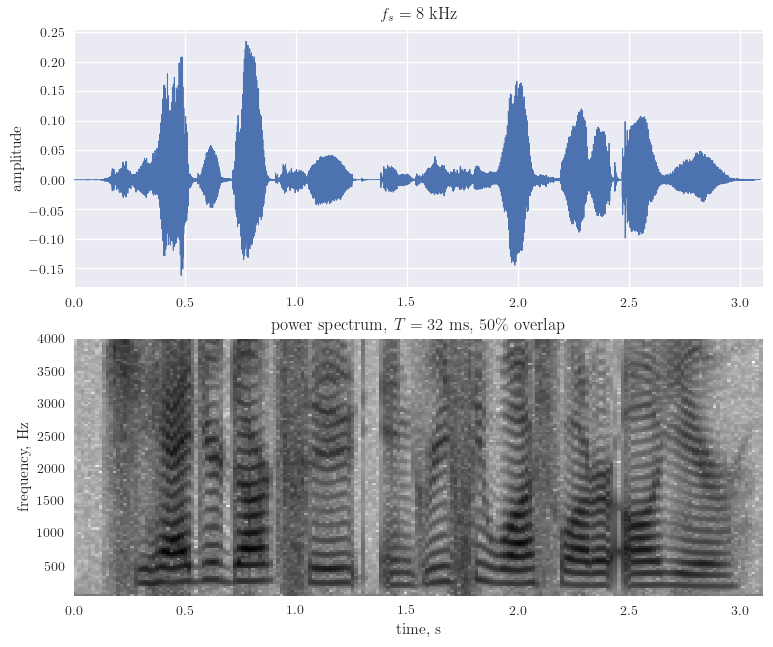

In [9]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/TIMIT/data/lisa/data/timit/raw/TIMIT/TRAIN/DR8/FBCG1/'
cse = SpeechCS(traindir + 'SA1.wav', 
               rate=None, 
               downsample=True, 
               downrate=8000)
cse.displayData(seglen=int(cse.rate*32e-3), 
                pc_overlap=0.5)
disp.Audio(cse.data, rate=cse.rate)

In [100]:
seglen = int(cse.rate * 32e-3)
percent_overlap = 0.5
hop_size = int(seglen * percent_overlap)
fx, tx, Zxx = sig.stft(cse.data.real, cse.rate, nperseg=seglen, noverlap=hop_size, window='hann', return_onesided=True)
starts = np.arange(0, cse.data.size, seglen - hop_size, dtype=int)
starts = starts[starts + seglen < cse.data.size]
w = sig.get_window('hann', seglen + 1)[:-1]
x_train = Zxx.reshape((129, 15, -1))

In [102]:
x_train.shape

(129, 15, 13)